In [1]:
import matlab.engine
import numpy as np
import scipy.optimize

# Trial and pd parameters

In [2]:
# trial and adherence information
drug = "ATV/r"

days = np.double(40) #days to run trial for
increment = 0.01 # days between each timepoint returned
prob_adh = 0.5 if drug != 'TEST' else 0. # probability of taking each pill (independent)
adh_pat = 0 # 0 = random prob for each dose, 1 = random prob each day after missed dose
adh_shuff = np.double(0.) # standard deviation in the time of taking a pill vs scheduled (days)
trial_type = 1 # 1 = suppression trial, 0=maintenance trial
burnin = 7*5 # days before interval sampling begins in maintenance trials
sampling_int = 28 # days between each sampling time in maintenance trials
threshold = 200 # threshold viral load above which failure is declared
mut_frac = 0.2 # threshold fraction of population of mutant above which declared failure via resistance

## Use existing matlab scripts to calculate concentration(t)

In [3]:
eng = matlab.engine.start_matlab()
eng.cd(r'~/develop/withinhostHIV/MatlabCode/', nargout=0)
eng.eval("addpath('Parameters','Utilities')", nargout=0)

In [ ]:
eng.workspace["drug"] = drug
trial, pd = eng.trial_setup(eng.eval("drug"), days, increment, prob_adh, adh_pat, adh_shuff, trial_type, burnin, sampling_int, threshold, mut_frac, nargout=2)
eng.workspace["trial"] = trial
eng.workspace["pd"] = pd

In [ ]:
dose_t, _ = eng.adh_trajectory(eng.eval("pd.num_doses"), trial, nargout=2)

In [ ]:
c_vec,inhib_vec = eng.drug_trajectory(pd, trial, dose_t, nargout=2)

## Use existing matlab scripts to calculate mutation matrix Q

In [ ]:
smin=0.05; #highest mutant fitness
smax=0.9; #lowest mutant fitness
smiss=0.05; #fitness of strains with missing cost
rfmiss=1; #fold change in resistance for strains with it missing
mfmiss=0; #fractional change in slope for strains with it missing
back_mutation_on = drug != 'TEST' #include(1) or exclude(0) back mutation
direct_multi_hit = drug != 'TEST' #include(1) or exclude(0) direct multi-hit mutations from WT
direct_multi_multi = drug != 'TEST' #include(1) or exclude(0) direct multi-hit mutations from one res strain to another

In [ ]:
mparams,Q = eng.getMutInfo(drug,smin,smax,smiss,rfmiss,mfmiss,back_mutation_on,direct_multi_hit,direct_multi_multi,nargout=2);
eng.workspace["Q"] = Q
Q = eng.eval("Q{:,:};") # get a matrix instead of a matlab table

## Viral dynamics parameters

In [ ]:
R00 = 10.0 # average number of new virions produced by infection with a single virion === average number of new infected cells produced by 1 infected cell
fbp = 0.55 # fraction of blood that is plasma
Vpl = 3*10e3 # volume of plasma in mL
ftcell_pl = 0.02 # fraction of T cells that are circulating in blood (vs in lymph system)
hl_lr = 44*30.5 # half life of decay of latent reservoir, days
A = 100 # total reactivation of latent cells per day
flr = 1e-6# fraction of CD4 T cells that are latently infected at equilibrium

scale_cd4_body = (Vpl*10**3)/(fbp*ftcell_pl) # factor to go from T cell per ul blood to whole body

fa = 0.01 # fraction of infected CD4 cells that support productive vs abortive infection
dx = 0.05 # death rate of uninfected cells (per day) and by assumption dx == d, rate of death without viral cytolytic effects
L = scale_cd4_body*1000*dx # uninfected cells produced per day (/ul)
a = A/(flr*L/dx) # rate of exit of latent cells (per day)
dz = np.log(2)/(hl_lr)-a # death rate of latently infected cells (per day)

dy = 1 # TOTAL death rate of infected cells (per day) (=death due to burst (k) + death without viral cytolytic effects)
k = dy-dx # rate of death+emission of a burst of virions (per day)
N = 2.38e5
assert(N > R00)

# probability of a single virion establishing infection, solved implicitly
p_est_solution = scipy.optimize.least_squares(lambda p_est: R00*(1-(1-p_est)**N) - N*p_est, 0.1)
assert(p_est_solution.success)
p_est = p_est_solution.x

dv = 25 # TOTAL death rate of virions (per day)
beta = R00 * dy * dv * dx / (k * N * fa * L) # infectivity rate (per day*infectious-target cell pair)
c = dv-beta*L/dx # clearance rate of virions (per day);
assert(c > 0)
g = flr*dy/dx*(a+dz)/(fa*(1-1/R00)) # fraction of new infections that become latent

In [ ]:
# Access matlab parameters
eng.workspace["mparams"] = mparams
IC50 = eng.eval('pd.IC50')
m = eng.eval('pd.m')
cost = eng.eval('mparams.cost')
rf = eng.eval('mparams.rf')
mf = eng.eval('mparams.mf')
msb = np.asarray(eng.eval("mparams.msb"))
t_vec = eng.eval('(0:trial.increment:trial.days);')


## Check beta(t) (from matlab) against beta(t) (from python)

In [ ]:
_beta_t, _beta_u_t = eng.calculate_beta_of_t(t_vec, beta, c_vec, IC50, m, cost, rf, mf, eng.eval('height(mparams)'), nargout=2)

In [ ]:
from numba import jit

@jit(nopython=True)
def calculate_beta_t(beta_0, concentration, IC50, m, cost, rf, mf):
    # B/[cost * (1 + concentration)/(IC50*rf)^(m*(1+mf))]
    B = beta_0
    denominator = cost * (1 + (concentration/(IC50*rf))**(m*(1+mf)))
    return B/denominator


# make sure we didn't mess up our function definition
assert(np.allclose(calculate_beta_t(beta, np.asarray(c_vec), IC50, m, np.asarray(cost).T, np.asarray(rf).T, np.asarray(mf).T), np.asarray(_beta_u_t)))
assert(np.allclose(calculate_beta_t(beta, np.asarray(c_vec), IC50, m, 1, 1, 1), np.asarray(_beta_t)))

beta_u_t = calculate_beta_t(beta, np.asarray(c_vec), IC50, m, np.asarray(cost).T, np.asarray(rf).T, np.asarray(mf).T)
beta_t   = calculate_beta_t(beta, np.asarray(c_vec), IC50, m, 1, 1, 1)

beta_t = np.concatenate([beta_t, beta_u_t], axis=1)
t_vec = np.asarray(t_vec).squeeze()
dose_t = np.asarray(dose_t).T.squeeze()

In [ ]:
beta_t

array([[5.72353685e-29, 1.80640339e-19, 3.44853164e-20, 1.34826435e-18],
       [6.42910440e-29, 1.87704557e-19, 3.58339359e-20, 1.40343211e-18],
       [7.22165060e-29, 1.95045026e-19, 3.72352957e-20, 1.46085702e-18],
       ...,
       [5.04088889e-19, 3.34240624e-16, 6.53918872e-17, 3.03318773e-15],
       [5.66229450e-19, 3.46864531e-16, 6.79253626e-17, 3.13599429e-15],
       [6.36030146e-19, 3.59947719e-16, 7.05560340e-17, 3.24154368e-15]])

In [ ]:
sampled_concentration = np.asarray(c_vec)

increment = eng.eval('trial.increment')

# closed around parameters
# pulls the nearest beta pre-calculated to the left of the current time
@jit(nopython=True)
def discrete_beta_of_t(t):
    # last time where beta was precalculated *before* t
    # specifically want *before* t so that we don't look ahead while integrating past a discontinuity
    t_discrete = int(np.floor(t/increment))
    return beta_t[t_discrete]

Q = np.asarray(Q)
@jit(nopython=True)
def force_of_infection(t):
    beta = discrete_beta_of_t(t)
    # calculate force of infection and flatten in row major order, which will make the matrix
    # read correctly in our 1-dimensional vector of rates

    # **NOTE* we moved FA to the stoichiometry matrix, otherwise it would be a factor below!
    return (np.expand_dims(beta,1) * Q).flatten()

TODO: triple check to make sure this is the right orientation of beta_i relative to Q

In [ ]:
Q

array([[1.00000000e+00, 9.31401597e-07, 1.15302567e-05, 1.15302033e-05],
       [6.38285140e-06, 1.00000000e+00, 7.35959154e-11, 7.35955744e-11],
       [4.29936191e-05, 4.00443255e-11, 1.00000000e+00, 4.95725170e-10],
       [2.62179380e-05, 2.44194294e-11, 3.02299557e-10, 1.00000000e+00]])

In [ ]:
print(Q[0,1], Q[1,0], ". Q[0,1] > Q[1,0]:", Q[0,1] > Q[1,0])

9.314015974243431e-07 6.382851399191302e-06 . Q[0,1] > Q[1,0]: False


In [ ]:
row_i, col_i = np.triu_indices_from(Q)
for i,j in zip(list(row_i), list(col_i)):
    print(Q[i,j] > Q[j,i])

False
False
False
False
False
True
True
False
True
False


In [ ]:
np.expand_dims(beta_t[0],1)

array([[5.72353685e-29],
       [1.80640339e-19],
       [3.44853164e-20],
       [1.34826435e-18]])

# Define model

In [ ]:
import reactionmodel.model as reactionmodel
num_strains = beta_t.shape[1]
num_strains

4

In [ ]:
ys = [reactionmodel.Species(f'infected cells strain {i}', f'y{i}') for i in range(num_strains)]
zs = [reactionmodel.Species(f'latent cells strain {i}', f'z{i}') for i in range(num_strains)]
vs = [reactionmodel.Species(f'viruses strain {i}', f'v{i}') for i in range(num_strains)]
x = reactionmodel.Species("target cells", "x")
all_species = [x] + ys + vs + zs

In [ ]:
target_cell_birth = reactionmodel.Reaction([], [x], description="target cell birth", k=L)
target_cell_death = reactionmodel.Reaction([x], [], description="target cell death", k=dx)
infected_death = [reactionmodel.Reaction([ys[i]], [], description=f"death of infected cell strain {i}", k=(dy-k)) for i in range(num_strains)]
infected_cell_burst = [reactionmodel.Reaction([ys[i]], [(vs[i], N)], description=f"burst of infected cell strain {i}", k=k) for i in range(num_strains)]
into_latency = [reactionmodel.Reaction([ys[i]], [zs[i]], description=f"strain {i} --> latency", k=g) for i in range(num_strains)]
out_of_latency = [reactionmodel.Reaction([zs[i]], [ys[i]], description=f"latent --> strain {i}", k=a) for i in range(num_strains)]
death_of_latent = [reactionmodel.Reaction([zs[i]], [], description=f"latent {i} death", k=dz) for i in range(num_strains)]
viral_clearance = [reactionmodel.Reaction([vs[i]], [], description=f"clearance of strain {i} virion", k=c) for i in range(num_strains)]

infections = []
for i in range(num_strains):
    for j in range(num_strains):
        infections.append(reactionmodel.Reaction([x, vs[i]], [(ys[j], fa)], description=f"infection of x by {i}->{j}"))
infection_family = reactionmodel.ReactionRateFamily(infections, k=force_of_infection)

all_reactions = [target_cell_birth, target_cell_death] + infected_death + infected_cell_burst + into_latency + out_of_latency + death_of_latent + viral_clearance + [infection_family]


In [ ]:
for r in all_reactions:
    if isinstance(r, list):
        print(r)

In [ ]:
from numba.core.registry import CPUDispatcher
isinstance(all_reactions[-1].k, CPUDispatcher)

True

In [ ]:
model = reactionmodel.Model(all_species, all_reactions)

In [ ]:
for reaction in model.all_reactions:
    print(reaction)

Reaction(description=target cell birth, reactants=(), products=(Species(name='target cells', description='x'),), kinetic_order=(), k=136363636363.63635)
Reaction(description=target cell death, reactants=(Species(name='target cells', description='x'),), products=(), kinetic_order=(Species(name='target cells', description='x'),), k=0.05)
Reaction(description=death of infected cell strain 0, reactants=(Species(name='infected cells strain 0', description='y0'),), products=(), kinetic_order=(Species(name='infected cells strain 0', description='y0'),), k=0.050000000000000044)
Reaction(description=death of infected cell strain 1, reactants=(Species(name='infected cells strain 1', description='y1'),), products=(), kinetic_order=(Species(name='infected cells strain 1', description='y1'),), k=0.050000000000000044)
Reaction(description=death of infected cell strain 2, reactants=(Species(name='infected cells strain 2', description='y2'),), products=(), kinetic_order=(Species(name='infected cells s

# Run forward simulation

In [ ]:
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

In [ ]:
ys

[Species(name='infected cells strain 0', description='y0'),
 Species(name='infected cells strain 1', description='y1'),
 Species(name='infected cells strain 2', description='y2'),
 Species(name='infected cells strain 3', description='y3')]

In [ ]:
extra_discontinuities = list(np.linspace(0.0,40.0,400))
extra_discontinuities = []

y0 = np.zeros(len(all_species))
y0[model.species_index[x]] = L/dx/R00

expanded_msb = np.squeeze(np.vstack([np.array([1]), msb]))
y0[model.species_index[ys[0]] : model.species_index[ys[-1]] + 1] = fa*(1-1/R00)*L/dy * expanded_msb
y0[model.species_index[zs[0]] : model.species_index[zs[-1]] + 1] = y0[model.species_index[ys[0]] : model.species_index[ys[-1]] + 1] * g/(a+dz)

In [ ]:
y0[model.species_index[zs[0]] : model.species_index[zs[-1]] + 1]

array([2.72727273e+06, 3.38679202e+00, 3.83408502e+01, 5.72193503e+01])

In [ ]:
y0[model.species_index[zs[3]]] / (L/dx) * 1e6

2.098042843818336e-05

In [ ]:
%load_ext jupyterflame

In [ ]:
%%time

# the adherence pattern and hence the R0s is being determined in matlab before any of this code runs,
# so don't be scared if trajectories look almost identical with different seeds in python

simulator = HybridSimulator(
    model.get_k(jit=True),
    model.stoichiometry(),
    model.kinetic_order(),
    FixedThresholdPartitioner(1000).partition_function,
    discontinuities=np.sort(np.array(list(dose_t)+extra_discontinuities)),
    jit=True
)

rng = np.random.default_rng(0)
result = simulator.simulate([0, 40.0], y0, rng)

print(result.status_counter)

Doing surgery to avoid discontinuity: skipping from 0.9999999999999999 to 1.0000000000000002
Doing surgery to avoid discontinuity: skipping from 2.9999999999999996 to 3.0000000000000004
Doing surgery to avoid discontinuity: skipping from 3.9999999999999996 to 4.000000000000001
Doing surgery to avoid discontinuity: skipping from 6.999999999999999 to 7.000000000000001
Doing surgery to avoid discontinuity: skipping from 7.999999999999999 to 8.000000000000002
Doing surgery to avoid discontinuity: skipping from 8.999999999999998 to 9.000000000000002
Doing surgery to avoid discontinuity: skipping from 10.999999999999998 to 11.000000000000002
Doing surgery to avoid discontinuity: skipping from 11.999999999999998 to 12.000000000000002
Doing surgery to avoid discontinuity: skipping from 13.999999999999998 to 14.000000000000002
Doing surgery to avoid discontinuity: skipping from 16.999999999999996 to 17.000000000000004
Doing surgery to avoid discontinuity: skipping from 17.999999999999996 to 18.

In [ ]:
np.sort(np.array(list(dose_t)+extra_discontinuities)),

(array([ 0.,  1.,  3.,  4.,  7.,  8.,  9., 11., 12., 14., 17., 18., 19.,
        20., 22., 23., 24., 25., 26., 28., 30., 35., 36., 38.]),)

In [ ]:
%%time

# the adherence pattern and hence the R0s is being determined in matlab before any of this code runs,
# so don't be scared if trajectories look almost identical with different seeds in python

simulator = HybridSimulator(
    model.get_k(jit=True),
    model.stoichiometry(),
    model.kinetic_order(),
    FixedThresholdPartitioner(1000).partition_function,
    discontinuities=np.sort(np.array(list(dose_t)+extra_discontinuities)),
    jit=True,
    approximate_rtot=True,
    contrived_no_reaction_rate=1.,
    partition_fraction_for_halt=0.8
)

rng = np.random.default_rng(0)
result = simulator.simulate([0, 40.0], y0, rng)

print(result.status_counter)

Doing surgery to avoid discontinuity: skipping from 0.9999999999999999 to 1.0000000000000002
Doing surgery to avoid discontinuity: skipping from 2.9999999999999996 to 3.0000000000000004
Doing surgery to avoid discontinuity: skipping from 3.9999999999999996 to 4.000000000000001
Doing surgery to avoid discontinuity: skipping from 6.999999999999999 to 7.000000000000001
Doing surgery to avoid discontinuity: skipping from 7.999999999999999 to 8.000000000000002
Doing surgery to avoid discontinuity: skipping from 8.999999999999998 to 9.000000000000002
Doing surgery to avoid discontinuity: skipping from 10.999999999999998 to 11.000000000000002
Doing surgery to avoid discontinuity: skipping from 11.999999999999998 to 12.000000000000002
Doing surgery to avoid discontinuity: skipping from 13.999999999999998 to 14.000000000000002
Doing surgery to avoid discontinuity: skipping from 16.999999999999996 to 17.000000000000004
Doing surgery to avoid discontinuity: skipping from 17.999999999999996 to 18.

In [ ]:
result

History(t=40.0, y=array([2.39413662e+12, 7.04340000e+04, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 6.66581964e+08, 0.00000000e+00, 8.92340000e+04,
       2.73492000e+05, 2.67288200e+06, 4.00000000e+00, 3.80000000e+01,
       5.90000000e+01]), t_history=array([0.00000000e+00, 0.00000000e+00, 1.08109343e-17, ...,
       3.99985512e+01, 3.99988614e+01, 4.00000000e+01]), y_history=array([[2.72727273e+11, 2.72727273e+11, 2.72727273e+11, ...,
        2.39411249e+12, 2.39411765e+12, 2.39413662e+12],
       [1.22727273e+09, 1.22727273e+09, 1.22727273e+09, ...,
        7.05356035e+04, 7.05137303e+04, 7.04340000e+04],
       [1.52405641e+03, 1.52405641e+03, 1.52405641e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.38679202e+00, 3.38679202e+00, 3.38679202e+00, ...,
        4.00000000e+00, 4.00000000e+00, 4.00000000e+00],
       [3.83408502e+01, 3.83408502e+01, 3.83408502e+01, ...,
        3.80000000e+01, 3.80000000e+01, 3.80000000e+01],
     

In [ ]:
scale_cd4_body=(Vpl*10**3)/(fbp*ftcell_pl)
#scale_cd4_virus=kdv*2*1e3/fbp

(1e-07, 1000.0)

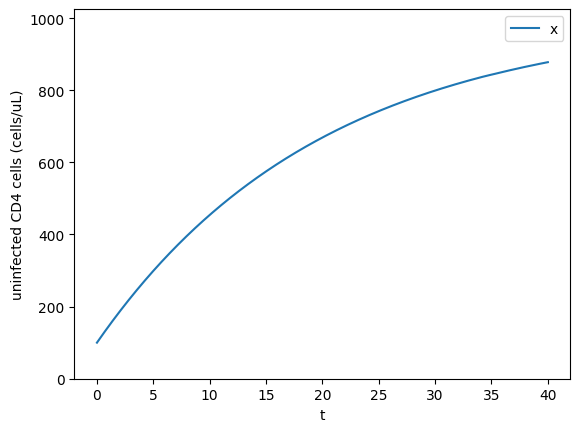

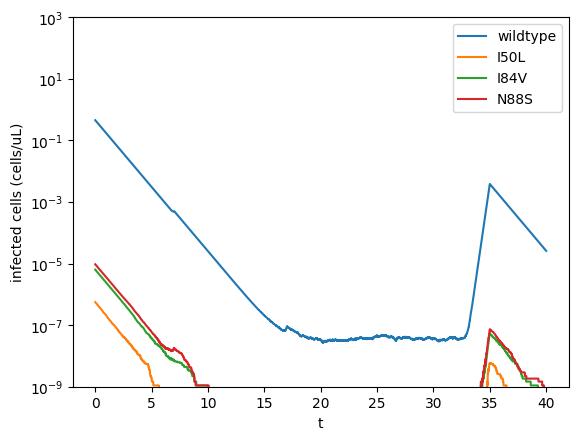

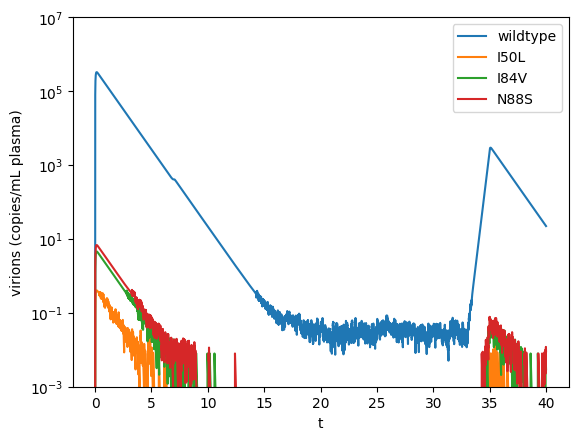

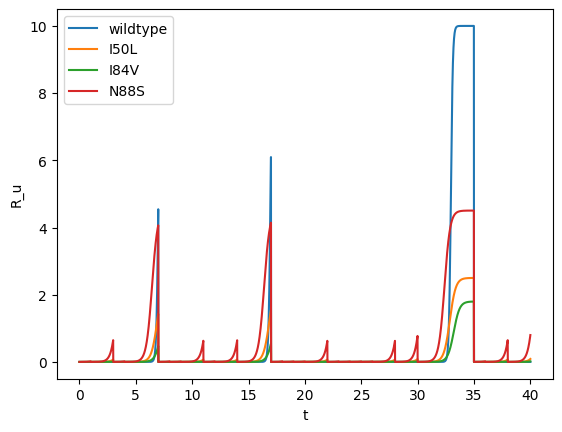

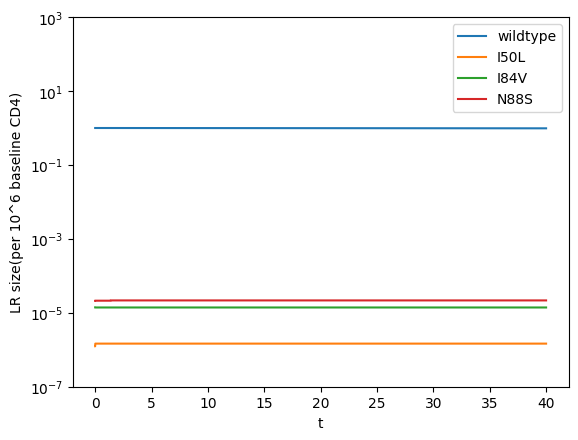

In [ ]:
mnames = list(np.asarray(eng.eval('mparams.Properties.RowNames')))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(result.t_history, result.y_history[0].T/scale_cd4_body, label='x')
plt.yscale('linear')
plt.ylabel('uninfected CD4 cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([0, 1025])

plt.figure()
plt.plot(result.t_history, result.y_history[1:1+len(ys)].T/scale_cd4_body, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('infected cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-9, 1e3])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(vs[0]):model.species.index(vs[-1])+1].T/Vpl/1000, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('virions (copies/mL plasma)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-3, 1e7])

plt.figure()
plt.plot(t_vec, beta_t*R00/beta, label=['wildtype']+mnames)
plt.legend()
plt.ylabel('R_u')
plt.xlabel('t')
plt.yscale('linear')

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1].T*(10**6)/(L/dx), label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('LR size(per 10^6 baseline CD4)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-7, 10e2])

In [ ]:
result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1][:,-1]/(10**6)/(L/dx)

array([9.80056733e-13, 1.46666667e-18, 1.39333333e-17, 2.16333333e-17])

In [ ]:
def dydt_factory(calculate_propensities):
    def dydt(t, y_expanded, k, deterministic_mask, stochastic_mask, hitting_point):
        y = y_expanded[:-1]
        k = k(t)
        propensities = calculate_propensities(y, k)
        deterministic_propensities = propensities * deterministic_mask
    
        deterministic_propensities
        dydt = np.zeros(len(y_expanded))
    
        ## reaction rates used multiple times 
        _infections = deterministic_propensities[r.index(viral_clearance[-1])+1:len(r)].reshape(n, n)
        new_infections_by_strain = _infections.sum(axis=0)
        loss_of_virions_by_strain = _infections.sum(axis=1)
    
        ic_death = deterministic_propensities[r.index(infected_death[0]):r.index(infected_death[0])+n]
        ic_burst = deterministic_propensities[r.index(infected_cell_burst[0]):r.index(infected_cell_burst[0])+n]
        to_latent = deterministic_propensities[r.index(into_latency[0]):r.index(into_latency[0])+n]
        from_latent = deterministic_propensities[r.index(out_of_latency[0]):r.index(out_of_latency[0])+n]
    
        ## Infected cells
        dydt[1:1+n] = (
            fa * new_infections_by_strain
            + from_latent
            - ic_death
            - ic_burst
            - to_latent
        )
    
        ## Virions
        dydt[1+n:1+2*n] = (
            burst_size * ic_burst
            - loss_of_virions_by_strain
            - deterministic_propensities[r.index(viral_clearance[0]):r.index(viral_clearance[0])+n]
        )
    
        ## Latent cells
        dydt[species.index(zs[0]):species.index(zs[0])+n] = (
            to_latent
            - from_latent
            - deterministic_propensities[r.index(death_of_latent[0]):r.index(death_of_latent[0])+n]
        )
    
        ## Target cells
        dydt[species.index(x)] = deterministic_propensities[r.index(target_cell_birth)] - deterministic_propensities[r.index(target_cell_death)] - np.sum(loss_of_virions_by_strain)
        dydt[-1] = np.sum(propensities * stochastic_mask)
        return dydt
    return dydt

In [ ]:
#rates = N @ deterministic_propensities

#fa = 0.01
species = tuple(model.species.copy())
r = tuple(model.all_reactions.copy())
n = len(ys)
burst_size = N

num_pathways = len(r)
clearance_start = r.index(viral_clearance[0])
clearance_end = r.index(viral_clearance[-1])
ic_death_start = r.index(infected_death[0])
ic_burst_start = r.index(infected_cell_burst[0])
to_latent_start = r.index(into_latency[0])
from_latent_start = r.index(out_of_latency[0])
latent_death_start = r.index(death_of_latent[0])
target_birth = r.index(target_cell_birth)
target_death = r.index(target_cell_death)

latent_start = species.index(zs[0])
ic_start = species.index(ys[0])
virus_start = species.index(vs[0])
x_start = species.index(x)

def jit_dydt_factory(_):
    @jit(nopython=True)
    def dydt(t, y_expanded, k, deterministic_mask, stochastic_mask, calculate_propensities, hitting_point):
        y = y_expanded[:-1]
        propensities = calculate_propensities(y, k, t)
        deterministic_propensities = propensities * deterministic_mask
    
        deterministic_propensities
        dydt = np.zeros(len(y_expanded))
    
        ## reaction rates used multiple times 
        _infections = deterministic_propensities[clearance_end+1:clearance_end+1+n**2].reshape(n, n)
        new_infections_by_strain = _infections.sum(axis=0)
        loss_of_virions_by_strain = _infections.sum(axis=1)
    
        ic_death = deterministic_propensities[ic_death_start:ic_death_start+n]
        ic_burst = deterministic_propensities[ic_burst_start:ic_burst_start+n]
        to_latent = deterministic_propensities[to_latent_start:to_latent_start+n]
        from_latent = deterministic_propensities[from_latent_start:from_latent_start+n]
    
        ## Infected cells
        dydt[ic_start:ic_start+n] = (
            fa * new_infections_by_strain
            + from_latent
            - ic_death
            - ic_burst
            - to_latent
        )
    
        ## Virions
        dydt[virus_start:virus_start+n] = (
            burst_size * ic_burst
            - loss_of_virions_by_strain
            - deterministic_propensities[clearance_start:clearance_start+n]
        )
    
        ## Latent cells
        dydt[latent_start:latent_start+n] = (
            to_latent
            - from_latent
            - deterministic_propensities[latent_death_start:latent_death_start+n]
        )
    
        ## Target cells
        dydt[x_start] = (
            deterministic_propensities[target_birth]
            - deterministic_propensities[target_death]
            - np.sum(loss_of_virions_by_strain)
        )
        
        dydt[-1] = np.sum(propensities * stochastic_mask)
        return dydt
    def wrapper(t, y_expanded, k, partition, calculate_propensities, hitting_point):
        return dydt(t, y_expanded, k, partition.deterministic, partition.deterministic, calculate_propensities, hitting_point)
    return wrapper

# Tau leaping

In [ ]:
from hybrid.tau import TauLeapSimulator

simulator = TauLeapSimulator(
    model.get_k(jit=True),
    model.stoichiometry(),
    model.kinetic_order(),
    #discontinuities=np.sort(np.array(list(dose_t)+extra_discontinuities)),
    jit=True,
)

In [ ]:
result = simulator.simulate([0, 40.0], np.round(y0), np.random.default_rng())

result.status_counter

/Users/thayer/develop/hybrid/hybrid/tau.py:61: RuntimeWarning: invalid value encountered in divide
  L = np.expand_dims(y,axis=1) / self.N[None, :]
/Users/thayer/develop/hybrid/hybrid/tau.py:94: RuntimeWarning: invalid value encountered in divide
  f_jjp = (((kinetic_order_matrix * propensities).T / y) @ N)
/Users/thayer/develop/hybrid/hybrid/tau.py:102: RuntimeWarning: divide by zero encountered in divide
  tau1 = np.min(epsilon * total_propensity / np.abs(mu_j)) # min'd over j
/Users/thayer/develop/hybrid/hybrid/tau.py:103: RuntimeWarning: divide by zero encountered in divide
  tau2 = np.min(epsilon**2 * total_propensity**2 / sigma_2_j) # min'd over j


Counter({<TauStepStatus.leap_critical_combined: 1>: 13531,
         <TauStepStatus.leap: 0>: 1003})

In [ ]:
result.y_history[:, 8001]

array([1.9371677e+12, 1.0285000e+02, 2.4200000e+00, 9.2200000e+00,
       9.3600000e+00, 4.7776000e+05, 0.0000000e+00, 9.0000000e+00,
       9.0000000e+00, 2.6967430e+06, 3.0000000e+00, 3.8000000e+01,
       5.7000000e+01])

(1e-07, 1000.0)

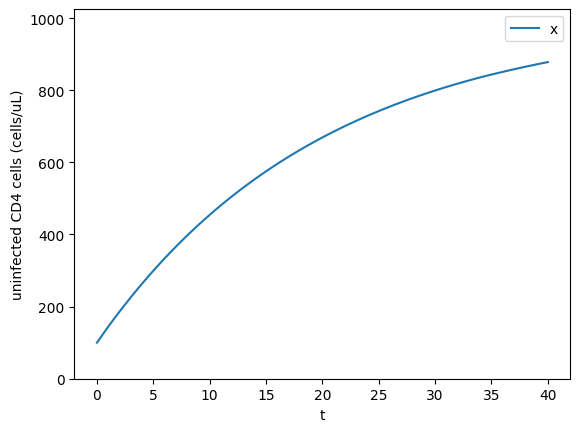

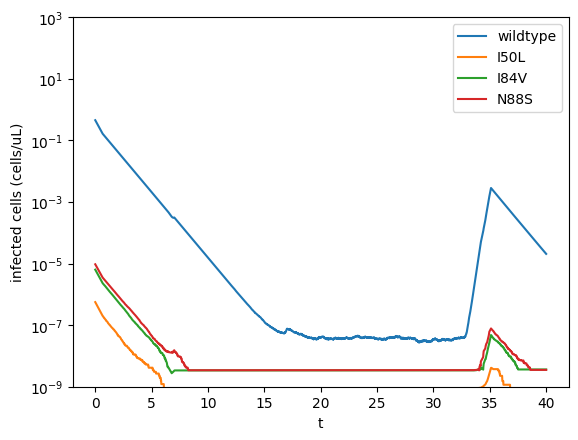

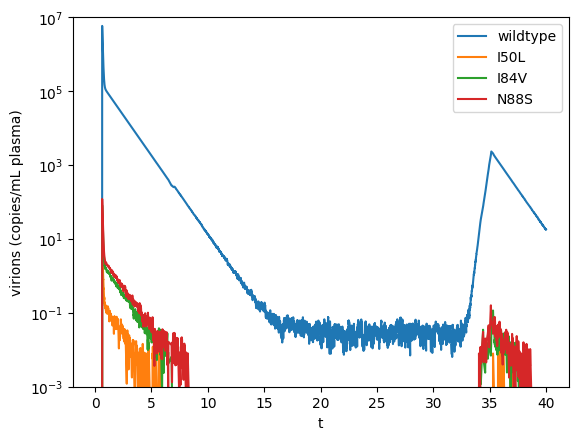

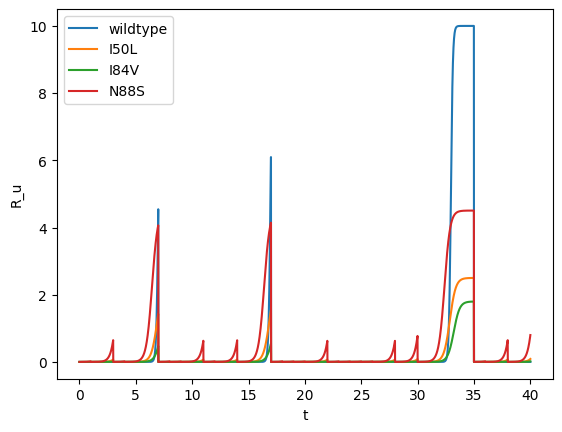

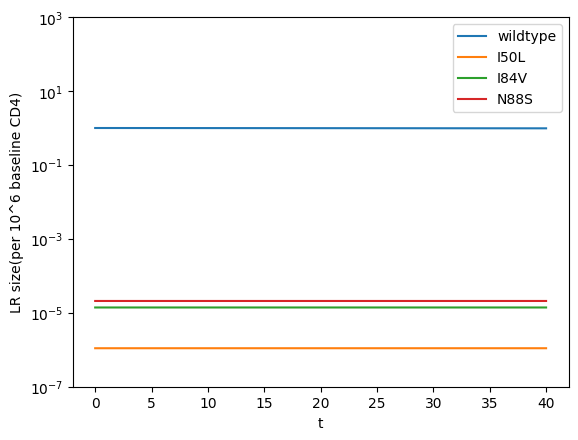

In [ ]:
mnames = list(np.asarray(eng.eval('mparams.Properties.RowNames')))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(result.t_history, result.y_history[0].T/scale_cd4_body, label='x')
plt.yscale('linear')
plt.ylabel('uninfected CD4 cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([0, 1025])

plt.figure()
plt.plot(result.t_history, result.y_history[1:1+len(ys)].T/scale_cd4_body, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('infected cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-9, 1e3])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(vs[0]):model.species.index(vs[-1])+1].T/Vpl/1000, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('virions (copies/mL plasma)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-3, 1e7])

plt.figure()
plt.plot(t_vec, beta_t*R00/beta, label=['wildtype']+mnames)
plt.legend()
plt.ylabel('R_u')
plt.xlabel('t')
plt.yscale('linear')

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1].T*(10**6)/(L/dx), label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('LR size(per 10^6 baseline CD4)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-7, 10e2])